# Hazard assessment for river flooding using flood maps


Click [![river flood](https://img.shields.io/badge/FLOOD-repository-blue)](https://github.com/CLIMAAX/FLOODS) to go to this workflow's GitHub repository.

In this workflow we will map the river flood hazard using widely available European and global datasets. For an overview of the datasets and their limitations please see the workflow description in the previous page or on [GitHub](https://github.com/CLIMAAX/FLOODS/blob/main/02_River_flooding/Risk_workflow_description_FLOOD_RIVER.md).

In this hazard assessment workflow we will first access and analyze the **JRC's high-resolution flood maps** to obtain the flood extents under extreme events with different statistical likelihood of occurence (available: 10, 20, 30, 40, 50, 75, 100, 200, 500 year return periods). We retrieve the relevant parts of the flood hazard dataset and explore it in more detail for the region of interest.

Secondly, we will check the likely impact of climate change on the river flood hazard under different climate scenarios by using the **Aqueduct Floods coarse-resolution flood maps**. By comparing flood maps under different climate scenarios we will get a qualitative indication of the effect of climate change on the extreme river dischages resulting in flooding.

Before proceeding with the hazard mapping, please take a moment to learn more about the background of the flood map datasets and learn what you should consider when using these datasets to assess flood risk in a local context:

`````{admonition} JRC high-resolution flood hazard maps for Europe in **historical** climate
:class: hint dropdown
The high-resolution river flood maps from JRC come at a spatial resolution of 3 arc-seconds (30-75m in Europe depending on latitude). Flood maps are available for various return periods (10, 20, 30, 40, 50, 75, 100, 200, 500 years).

The methodology behind this dataset is documented and can be accessed through this [article](https://doi.org/10.5194/essd-14-1549-2022). We will use the most recently updated version of the dataset (v3) that became available in March 2024. 

The dataset only includes the river basins larger than 150km2. The flood modelling in this dataset does not account for man-made protections that may already be in place in populated regions (e.g. dams, levees, dikes). Therefore, it is always important to survey the local circumstances when interpreting the flood maps.
`````

`````{admonition} Aqueduct Floods coarse-resolution flood maps - dataset of **future** river flood potential under climate change
:class: hint dropdown
This dataset has a resolution of 30 arc-seconds or 300-750m depending on the latitude (in Europe). This dataset includes flood maps for extreme flood events in the baseline climate (ca. 1980) and in the future climates (2030, 2050, 2080 for RCP4.5 and RCP8.5 climate scenarios). The methodology behind this dataset is available in the corresponding [technical note](https://www.wri.org/research/aqueduct-floods-methodology).

This is a global dataset which on a local scale may lead to considerable uncertainty in the results. Please keep the following in mind when interpreting the data from this dataset:
-	The flood maps provide a first indicative estimate and should be interpreted with care.
-	Results of all scenarios and all models should be consulted before drawing any conclusions on the potential future changes in flood depth.
-	The underlying hydrological model and flood mapping method have a relatively coarse resolution and thus only include local characteristics up to this level of detail. Water management, weirs and sluices are not included in the model.
-	The analysis is based on time-series of limited length and thus extreme value analysis for high return periods (50 years and higher) is very uncertain.
`````

## Preparation work

### Select area of interest
Before downloading the data, we will define the coordinates of the area of interest. Based on these coordinates we will be able to clip the datasets for further processing, and eventually display hazard and damage maps for the selected area.

To easily define an area in terms of geographical coordinates, you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com/) to select a region and get the coordinates. Make sure to select 'CSV' in the lower left corner and copy the values in the brackets below. Next to coordinates, please specify a name for the area which will be used in plots and saved results. Note that the coordinates are specified in WGS84 coordinates (EPSG:4326).

In [30]:
## name the area for saving datasets and plots# specify the coordinates of the bounding box

# Examples:
bbox = [8.480702,52.959337,9.128896,53.216668]; areaname = 'Bremen_Germany'
# bbox = [-1.6,46,-1.05,46.4]; areaname = 'La_Rochelle' 
#bbox = [-8.946851,38.505622,-8.821409,38.563009]; areaname = 'Setubal_Portugal'
#bbox = [12.1,45.1,12.6,45.7]; areaname = 'Venice'
#bbox = [-9.250441,38.354403,-8.618666,38.604761]; areaname = 'Setubal'

### Load libraries

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - Provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - A data retrieval and storage utility that simplifies downloading and managing datasets.
- [logging](https://docs.python.org/3/library/logging.html) - event logging system for libraries.
- [numpy](https://numpy.org/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/) - A data manipulation and analysis library, essential for working with structured data in tabular form.
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - A library for reading and writing geospatial raster data, providing functionalities to explore and manipulate raster datasets.
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data in GeoTIFF format.
- [xarray](https://docs.xarray.dev/en/stable/) - library for working with labelled multi-dimensional arrays.
- [damagescanner](https://damagescanner.readthedocs.io/en/latest/#) - A library designed for calculating flood damages based on geospatial data, particularly suited for analyzing flood impact.
- [matplotlib](https://matplotlib.org/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
- [contextily](https://contextily.readthedocs.io/en/latest/) A library for adding basemaps to plots, enhancing geospatial visualizations.


These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data, making them crucial for this risk workflow.
`````

In [31]:
# Package for downloading data and managing files
import os
import pooch

# Packages for working with numerical data and tables
import numpy as np
import pandas as pd

# Packages for handling geospatial maps and data
import rioxarray as rxr
import xarray as xr
import rasterio

# Ppackages used for plotting maps
import matplotlib.pyplot as plt
import contextily as ctx

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called 'FLOOD_RIVER_hazard' in the same directory where this notebook is saved.

In [32]:
# Define the folder for the flood workflow
workflow_folder = 'FLOOD_RIVER_hazard'

# Check if the workflow folder exists, if not, create it
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

general_data_folder = os.path.join(workflow_folder, 'general_data')

# Check if the general data folder exists, if not, create it
if not os.path.exists(general_data_folder):
    os.makedirs(general_data_folder)

In [33]:
# Define directories for data and plots within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Flood hazard mapping based on the JRC's high-resolution river flood map dataset for present-day scenario

### Download and view the JRC flood map dataset 

First we download the flood data for all available return periods.  

In the list of **return_periods**, first value is the return period, and second value is the hash.  

Next cell will:
- create the create the **data** folder inside the notebook folder
- Loop through all return periods and download and unzip each file in the data folder (if the data doesn't already exist).

Data for each return period can also be manually downloaded from [this link](https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-EFAS/flood_hazard/) in the JRC data portal.

In [34]:
# Define a list of return periods 
return_periods = [(10, 'd7353782de9577fb9dfda62cb0b8fd3f8c44926886e936bc09e0a21fabfa8e25'), 
                  #(20, '1fba8467810589ee1729435c490b0af1365520ea0fea948e036a012eec660d1c'), 
                  #(30, '6d8456314f90b2326de805bd730630cf4e2b1940574f3c134273cfd58f2307c1'), 
                  #(40, 'c6b10e138d9ac88f375bff1ffde46971df389480eafda17621c68b4676f77db8'), 
                  (50, 'ebfb5c969dad453fe915f2065e64b27df22517eba098dfa68d7d77c37c0904e5'), 
                  #(75, 'c7f864dad3e70cde53003f02edcbf4b4261d86c520379fc228d7c8e6be3de26e'), 
                  (100, 'bb7e33474f61fcbdd5bc08fbb584c34e94a5f23b259836c891f47717c1995a0e'), 
                  (200, '568c5fd1cc31b6873a1d98c7fef342e7530fa6c5f2f9fb8a3b6230d37bf90b20'), 
                  (500, 'b0585ae59bfcbfee776626f745bc78aae438a369e546286634bab3d0723a4121')]

# Disable info messages from pooch library to avoid too much output
logger = pooch.get_logger()
#logger.setLevel("WARNING")

# Loop through each return period and download the corresponding flood map
for item in return_periods:
    return_period, khash = item
    fname = f'Europe_RP{return_period}_filled_depth.tif'
    url = f'https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-EFAS/flood_hazard/Europe_RP{return_period}_filled_depth.tif'
    pooch.retrieve(
        url=url,
        known_hash=khash,
        path=general_data_folder,
        fname=fname,
    )

To check the dataset we select the 500 year return period map

In [35]:
# select first item from the search and open the dataset 
ds = rxr.open_rasterio(f"{general_data_folder}/Europe_RP500_filled_depth.tif")

We have opened the first dataset. The extent of the dataset is European, therefore the number of points along latitude and longitude axes is very large. This dataset needs to be clipped to our area of interest and reprojected to local coordinates (to view the maps with distances indicated in meters instead of degrees latitude/longitude). 

We can view the contents of the raw dataset.

In [36]:
ds

<xarray.DataArray (band: 1, y: 51992, x: 110162)> Size: 46GB
[5727542704 values with dtype=float64]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 881kB -24.54 -24.54 -24.54 ... 67.26 67.26 67.26
  * y            (y) float64 416kB 71.13 71.13 71.13 71.13 ... 27.81 27.81 27.81
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [37]:
ds.rio.resolution()

(0.0008333333333333334, -0.0008333333333333334)

Now we will clip the dataset to a wider area around the region of interest, and call it *ds_local*. The extra margin is added to account for reprojection at a later stage. The clipping of the dataset allows to reduce the total size of the dataset so that it can be loaded into memory for faster processing and plotting.

In [38]:
ds_local = ds.rio.clip_box(
    *bbox,
    crs="EPSG:4326", # provide the crs of the bounding box coordinates
)

# reproject ds_local to 3035
ds_local = ds_local.rio.reproject("EPSG:3035")

In [39]:
ds_local.rio.resolution()

(62.18203901064309, -62.18203901064309)

We can now plot the dataset to view the flood map a return period. You can adjust the bounds of the colorbar by changing the *vmax* variable to another value (in meters).

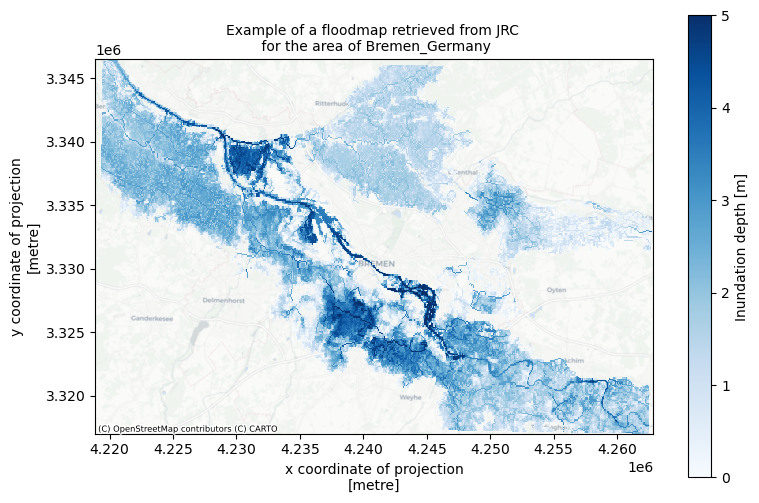

In [40]:
fig, ax = plt.subplots(figsize=(9, 6))
bs=ds_local.where(ds_local > 0).plot(ax=ax,cmap='Blues',alpha=1,vmin=0,vmax=5,add_colorbar=False)
ctx.add_basemap(ax=ax,crs='EPSG:3035',source=ctx.providers.CartoDB.Positron, attribution_size=6)
plt.title(f'Example of a floodmap retrieved from JRC \n for the area of {areaname}',fontsize=10);
fig.colorbar(bs, ax=ax, orientation="vertical", label='Inundation depth [m]');

### Combining all high-resolution flood maps with different return periods into one dataset
In our hazard and risk assessments, we would like to be able to compare the flood maps for different scenarios and return periods. For this, we will load and merge the datasets for different scenarios and return periods in one dataset, where the flood maps can be easily accessed. Below a function is defined which contains the steps described above for an individual dataset. 

In [41]:
# combine the above steps into a function to load flood maps per year and return period

def load_floodmaps(path):

    ds = rxr.open_rasterio(path)
    ds_local = ds.rio.clip_box(
    *bbox,
    crs="EPSG:4326", # provide the crs of the bounding box coordinates
    )

    # reproject ds_local to 3035
    ds_local = ds_local.rio.reproject("EPSG:3035")
    ds_floodmap = ds_local.where(ds_local > 0)
    del ds_local
    return ds_floodmap

We can now apply this function, looping over the selection of return periods. 


In [42]:
# load all floodmaps in one dataset

rps=[] # list of return periods 
for return_period, khash in return_periods:
    rps.append(return_period) 
    
import xarray as xr
for ii,rp in enumerate(rps):
    path = f"{general_data_folder}/Europe_RP{rp}_filled_depth.tif"
    ds = load_floodmaps(path)
    ds.name = f'RP{rp}' # set name of the dataset

    if ii==0:
        floodmaps = ds
    else:
        # use xarray to merge the datasets
        # different return periods are stored as different coordinates
        floodmaps = xr.merge([floodmaps,ds],combine_attrs="drop_conflicts")
        
    del ds       

floodmaps

<xarray.Dataset> Size: 13MB
Dimensions:      (x: 707, y: 474, band: 1)
Coordinates:
  * x            (x) float64 6kB 4.219e+06 4.219e+06 ... 4.263e+06 4.263e+06
  * y            (y) float64 4kB 3.346e+06 3.346e+06 ... 3.317e+06 3.317e+06
  * band         (band) int32 4B 1
    spatial_ref  int32 4B 0
Data variables:
    RP10         (band, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    RP50         (band, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    RP100        (band, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    RP200        (band, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
    RP500        (band, y, x) float64 3MB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

The *floodmaps* variable now contains the flood maps for different return periods. We can continue with viewing the contents.

### Visualize JRC's river flood hazard dataset for the present scenario and different return periods
Now we can compare the maps of flood potential in different different return periods. We will plot the maps next to each other.

To understand the range of flood depth values we will check the maximum flood depth in the data:

In [43]:
# get the maximum value of all data variables in floodmaps
floodmaps.max()

<xarray.Dataset> Size: 44B
Dimensions:      ()
Coordinates:
    spatial_ref  int32 4B 0
Data variables:
    RP10         float64 8B 4.601
    RP50         float64 8B 5.087
    RP100        float64 8B 5.242
    RP200        float64 8B 5.385
    RP500        float64 8B 5.546

Very high values for inundation depth can be found within the river contours, while we are more interested in the flood depth over the normally dry land. Based on the values above, we will choose the upper limit of inundation depth for visualization:

In [44]:
max_inundation = 5 

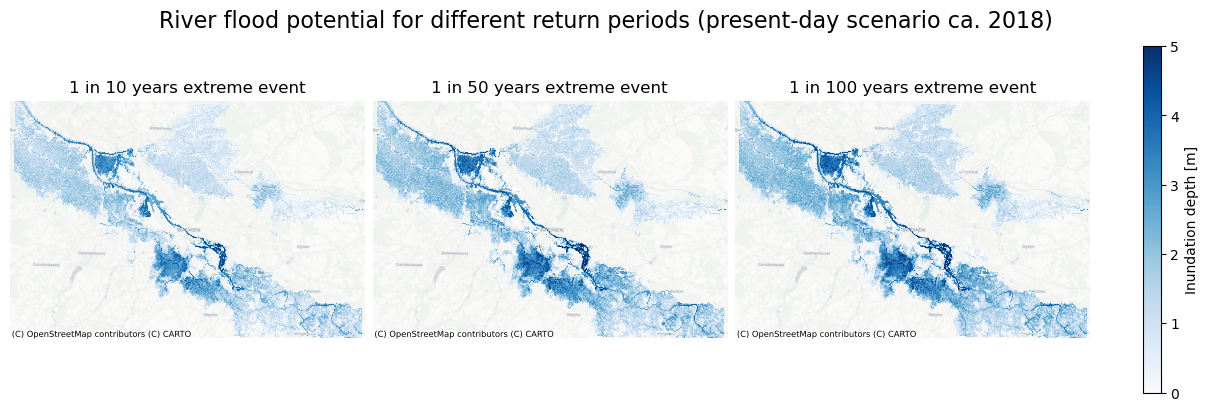

In [45]:
# select three return periods to visualize
rps_sel=[10,50,100]

# select return periods to visualize
fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=3, constrained_layout=True, sharex=True, sharey=True)

for ii, rp in enumerate(rps_sel):
    bs = floodmaps[f'RP{rp}'].plot(ax=axs[ii], cmap='Blues', vmin=0, vmax=max_inundation, add_colorbar=False)
    axs[ii].set_title(f'1 in {rp} years extreme event')
    ctx.add_basemap(ax=axs[ii], crs='EPSG:3035', source=ctx.providers.CartoDB.Positron, attribution_size=6)
    axs[ii].set_axis_off()

# Adjust how you set the colorbar to span all plots
fig.colorbar(bs, ax=axs.ravel().tolist(), orientation="vertical", label='Inundation depth [m]')  
fig.suptitle('River flood potential for different return periods (present-day scenario ca. 2018)', fontsize=16)

fileout = os.path.join(plot_dir, f'Floodmap_overview_JRC_PresentScenario_{areaname}.png')
fig.savefig(fileout)


### Save dataset of present-day flood hazard maps to a local directory for future access
Now that we have loaded the full dataset, we will save it to a local folder to be able to easily access it later for the risk assessment. There are two options for saving the dataset: as a single netCDF file containing all scenarios, and as separate raster files (**.tif** format).

In [46]:
# save the full dataset to netCDF file
fileout = os.path.join(data_dir,f'floodmaps_all_JRC_PresentScenario_{areaname}.nc')
floodmaps.to_netcdf(fileout) 
del fileout

In [ ]:
# save individual flood maps to raster files

for rp in rps: 
    floodmap_file = os.path.join(data_dir, f'floodmap_PresentScenario_{areaname}_{rp}.tif') 
    da = floodmaps[f'RP{rp}'][0] # select data array

    with rasterio.open(floodmap_file,'w',driver='GTiff',
        height=da.shape[0],
        width=da.shape[1],
        count=1,dtype=str(da.dtype),
        crs=da.rio.crs, transform=da.rio.transform()) as dst:
        dst.write(da.values,indexes=1) # Write the data array values to the rasterio dataset

## Estimating the effect of climate scenarios on the river flood hazard using the Aqueduct Floods river flood maps 

The coarse-resolution global flood maps for future scenarios are available from the [Aqueduct Floods data portal](https://www.wri.org/aqueduct).

We will make a comparison of flood maps under different scenarios just for one extreme return period, which is sufficient to make a qualitative assessment of the impact of climate scenarios. By selecting a higher return period we can check the effect of climate scenarios on the extremes associated with river flooding. In this example we will use the 1 in 250 years return period:

In [ ]:
return_period = 250

We will make a dedicated folder for saving data from Aqueduct Floods after it has been cropped to area of interest:

In [ ]:
data_dir_aqueduct = os.path.join(data_dir,'aqueduct_floods')
if not os.path.exists(data_dir_aqueduct):
    os.makedirs(data_dir_aqueduct)

### Load  and explore dataset for baseline scenario (ca. 1980) from the Aqueduct Floods dataset
We will first load a dataset with global flood maps for the base scenario, which is corresponding to year 1980 in the Aqueduct Flood Maps dataset: 

In [ ]:
aqueduct_filename_base = f'inunriver_historical_000000000WATCH_1980_rp{return_period:05}.tif'
aqueduct_filepath_base = os.path.join(general_data_folder,aqueduct_filename_base)

In [ ]:
# Check if dataset has not yet been downloaded
if  not os.path.isfile(aqueduct_filepath_base):
    # , define the URL for the flood map and download it
    url = f'http://wri-projects.s3.amazonaws.com/AqueductFloodTool/download/v2/{aqueduct_filename_base}'
    pooch.retrieve(url=url, known_hash=None, path=general_data_folder, fname=aqueduct_filename_base);
    print('Dataset dowloaded.')
else:
    print(f'Aqueduct flood map dataset already downloaded at {aqueduct_filepath_base}')

SHA256 hash of downloaded file: 6352ecd105747f114313b47db86944690740ebb005bd6f72fb5d8e1a3adc2873
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Dataset dowloaded.


We will now process this dataset by clipping it to the area of interest, reprojecting to local coordinates, adding information about the scenario and year to the dataset coordinates, and saving it to the local data directory for future use.

In [ ]:
out_path = os.path.join(data_dir_aqueduct,aqueduct_filename_base.replace('.tif',f'_{areaname}.nc'))

if not os.path.exists(out_path):

    with rxr.open_rasterio(aqueduct_filepath_base) as aq_floodmap:
        aq_floodmap_base = aq_floodmap.rio.clip_box(*bbox, crs=aq_floodmap.rio.crs)
        aq_floodmap_base = aq_floodmap_base.rio.reproject("epsg:3035")
        aq_floodmap_base = aq_floodmap_base.where(aq_floodmap_base > 0)
        aq_floodmap_base.name = 'inun'

        # write corresponding scenario year and scenario in the dataset coordinates
        aq_floodmap_base = aq_floodmap_base.assign_coords(year=1980); aq_floodmap_base = aq_floodmap_base.expand_dims('year') 
        aq_floodmap_base = aq_floodmap_base.assign_coords(scenario='baseline'); aq_floodmap_base = aq_floodmap_base.expand_dims('scenario') 
        aq_floodmap_base = aq_floodmap_base.to_dataset()
        aq_floodmap_base.to_netcdf(out_path)
else:
    aq_floodmap_base = xr.open_dataset(out_path)

# remove file with the global map extent from disk 
if os.path.exists(aqueduct_filepath_base):
    os.remove(aqueduct_filepath_base)

In [ ]:
aq_floodmap_base

<xarray.Dataset> Size: 29kB
Dimensions:      (x: 72, y: 49, band: 1, year: 1, scenario: 1)
Coordinates:
  * x            (x) float64 576B 4.219e+06 4.219e+06 ... 4.262e+06 4.263e+06
  * y            (y) float64 392B 3.347e+06 3.346e+06 ... 3.318e+06 3.317e+06
  * band         (band) int32 4B 1
    spatial_ref  int32 4B ...
  * year         (year) int32 4B 1980
  * scenario     (scenario) <U8 32B 'baseline'
Data variables:
    inun         (scenario, year, band, y, x) float64 28kB ...

We can make a plot to check the data resolution and agreement with the high-resolution dataset. Below the flood map for 1980, 1 in 250 year return period is plotted. We can see that the resolution is much coarser than the resolution of the JRC flood maps dataset. However, it will still be useful for comparing the effect of climate scenarios in qualitative way.

In [ ]:
# define discrete colormaps for plotting
cmap_flood = plt.get_cmap('Blues', 10) 
cmap_diff = plt.get_cmap('PuOr', 16) 

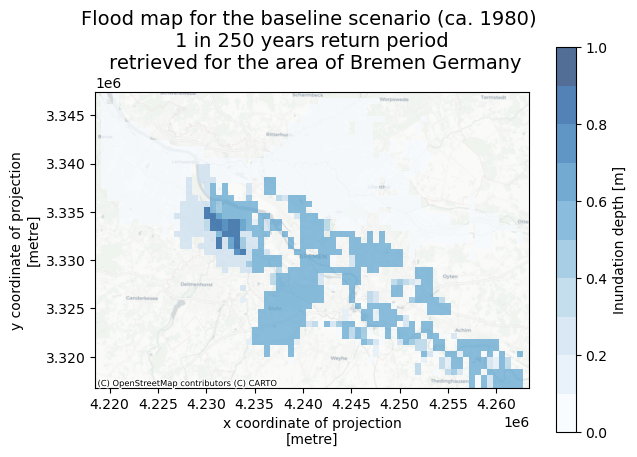

In [ ]:
# make plot of the baseline scenario flood map
cmap_flood = plt.get_cmap('Blues', 10) 
fig, ax = plt.subplots(figsize=(7, 5))
bs=aq_floodmap_base['inun'].plot(ax=ax,cmap=cmap_flood,alpha=0.7,vmin=0,vmax=np.ceil(np.nanmax(aq_floodmap_base['inun'].values)), cbar_kwargs={'label':'Inundation depth [m]'})
ctx.add_basemap(ax=ax,crs=aq_floodmap_base.rio.crs,source=ctx.providers.CartoDB.Positron, attribution_size=6)
plt.title(f'Flood map for the baseline scenario (ca. 1980) \n 1 in {return_period} years return period \n retrieved for the area of {areaname.replace("_"," ")}',fontsize=14);

### Load flood maps for all models and future scenarios from the Aqueduct Floods dataset

Now we can retrieve a collection of maps for the chosen return period, covering all available scenarios and models, to be able to estimate the change in river flood potential due to climate change.
The code below loops over the scenarios, years and climate models to retrieve the data and save it locally for the area of interest.

In [ ]:
models = ['NorESM1-M','GFDL-ESM2M','HadGEM2-ES','IPSL-CM5A-LR','MIROC-ESM-CHEM']
years = [2030, 2050, 2080]
scenarios = ['rcp4p5','rcp8p5']

In [ ]:
for scenario in scenarios:
    for year in years:
        for model in models:
            aqueduct_filename = f'inunriver_{scenario}_{model.rjust(14,"0")}_{year}_rp{return_period:05}.tif'
            aqueduct_filepath = os.path.join(general_data_folder,aqueduct_filename)
            out_path = os.path.join(data_dir_aqueduct,aqueduct_filename.replace('.tif',f'_{areaname}.nc'))

            if not os.path.exists(out_path):
                # download global dataset
                if  not os.path.isfile(aqueduct_filepath):
                    url = f'http://wri-projects.s3.amazonaws.com/AqueductFloodTool/download/v2/{aqueduct_filename}'
                    pooch.retrieve(url=url, known_hash=None, path=general_data_folder, fname=aqueduct_filename);
                    print(f'Dataset for {year}, {scenario}, {model} is dowloaded.')
                else:
                    print(f'Aqueduct flood map dataset for {year}, {scenario}, {model} already downloaded at {aqueduct_filepath}')

                # clip and reproject flood map, save to local data directory
                with rxr.open_rasterio(aqueduct_filepath) as aq_floodmap:
                    aq_floodmap_local = aq_floodmap.rio.clip_box(*bbox, crs=aq_floodmap.rio.crs)
                    aq_floodmap_local.load()
                    aq_floodmap_local = aq_floodmap_local.rio.reproject("epsg:3035")
                    aq_floodmap_local = aq_floodmap_local.where(aq_floodmap_local > 0)
                    aq_floodmap_local.name = 'inun'
                    
                    aq_floodmap_local = aq_floodmap_local.assign_coords(year=year); aq_floodmap_local = aq_floodmap_local.expand_dims('year') # write corresponding scenario year in the dataset coordinates
                    aq_floodmap_local = aq_floodmap_local.assign_coords(scenario=scenario); aq_floodmap_local = aq_floodmap_local.expand_dims('scenario') # write corresponding scenario 
                    aq_floodmap_local = aq_floodmap_local.assign_coords(model=model); aq_floodmap_local = aq_floodmap_local.expand_dims('model') # write corresponding model 
                    aq_floodmap_local = aq_floodmap_local.to_dataset()
                    aq_floodmap_local.to_netcdf(out_path)

                del aq_floodmap_local, aq_floodmap # delete variables that are no longer needed
                #os.remove(aqueduct_filepath) # delete global map files to save storage space
            else:
                print(f'Already exists: {out_path}')

Already exists: FLOOD_RIVER_hazard\data_Bremen_Germany\aqueduct_floods\inunriver_rcp4p5_00000NorESM1-M_2030_rp00250_Bremen_Germany.nc
Already exists: FLOOD_RIVER_hazard\data_Bremen_Germany\aqueduct_floods\inunriver_rcp4p5_0000GFDL-ESM2M_2030_rp00250_Bremen_Germany.nc
Already exists: FLOOD_RIVER_hazard\data_Bremen_Germany\aqueduct_floods\inunriver_rcp4p5_0000HadGEM2-ES_2030_rp00250_Bremen_Germany.nc
Already exists: FLOOD_RIVER_hazard\data_Bremen_Germany\aqueduct_floods\inunriver_rcp4p5_00IPSL-CM5A-LR_2030_rp00250_Bremen_Germany.nc
Already exists: FLOOD_RIVER_hazard\data_Bremen_Germany\aqueduct_floods\inunriver_rcp4p5_MIROC-ESM-CHEM_2030_rp00250_Bremen_Germany.nc
Already exists: FLOOD_RIVER_hazard\data_Bremen_Germany\aqueduct_floods\inunriver_rcp4p5_00000NorESM1-M_2050_rp00250_Bremen_Germany.nc
Already exists: FLOOD_RIVER_hazard\data_Bremen_Germany\aqueduct_floods\inunriver_rcp4p5_0000GFDL-ESM2M_2050_rp00250_Bremen_Germany.nc
Already exists: FLOOD_RIVER_hazard\data_Bremen_Germany\aqueduc

Now we can average the flood maps over models to have just one flood depth map per scenario and year, and save these flood maps to disk:

In [ ]:
filenames=[]
for scenario in scenarios:
    for year in years:
        for mname in models:
            filenames.append(os.path.join(data_dir_aqueduct,f'inunriver_{scenario}_{mname.rjust(14,"0")}_{year}_rp{return_period:05}_{areaname}.nc'))

with xr.open_mfdataset(filenames) as aq_floodmap_local:
    aq_floodmap_allmodels = aq_floodmap_local.mean(dim='model')
    aq_floodmap_allmodels.to_netcdf(os.path.join(data_dir_aqueduct,f'inunriver_AllScenarios_AllModels_AllYears_rp{return_period:05}_{areaname}.nc'))
    del aq_floodmap_allmodels

    # remove model-specific files 
    #os.remove(filenames)

KeyboardInterrupt: 

### Compare flood maps for different years and climate scenarios

To check the effect of climate change on the projected river flood depths corresponding to the extreme event with a given return period (in the example: 1 in 250 years event), we will plot the flood maps for different years (2030, 2050 and 2080) next to each other. We will do this for both climate scenarios (RCP4.5 and RCP8.5).
We will also plot the difference against the baseline situation with the same return period (baseline is ca. 1980 in this dataset).

In [ ]:
# load baseline flood map
aq_floodmap_base = xr.open_dataset(os.path.join(data_dir_aqueduct,f'inunriver_historical_000000000WATCH_1980_rp{return_period:05}_{areaname}.nc'))

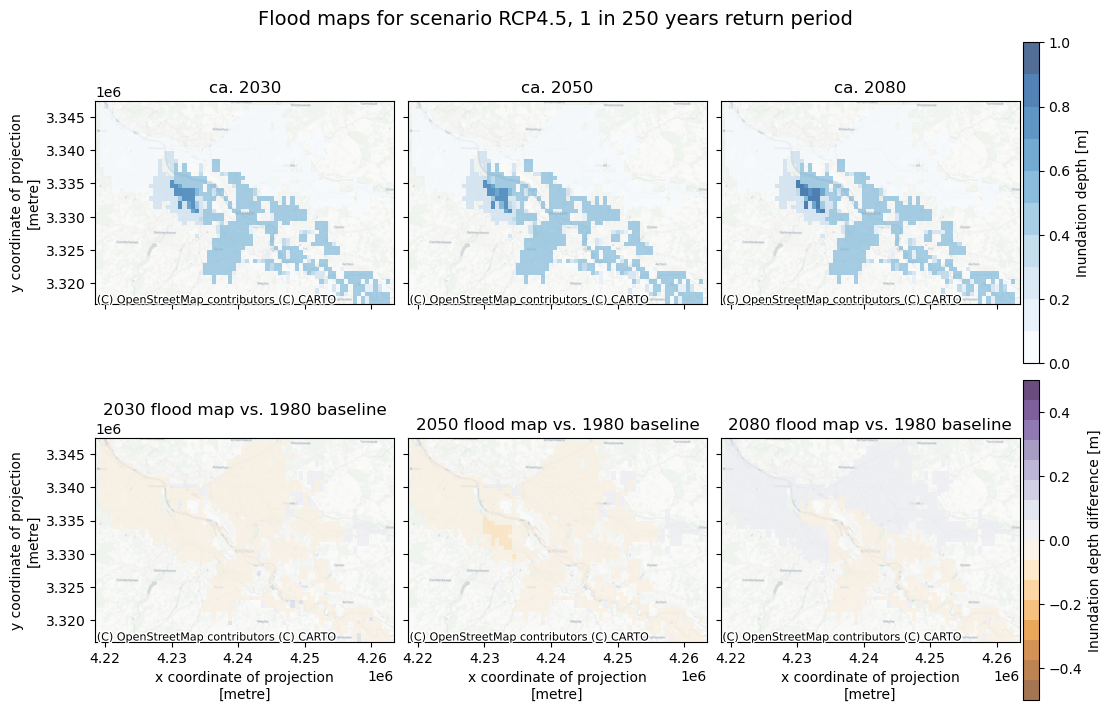

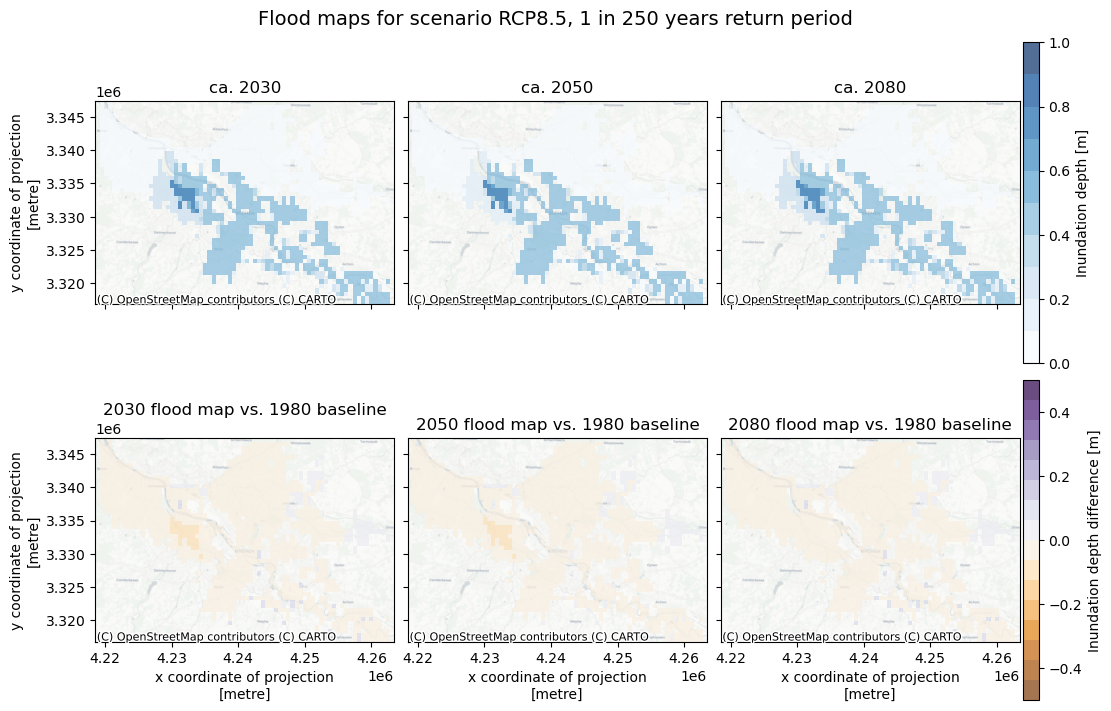

In [ ]:
# loop over scenarios and make plots
for scenario in scenarios:

    # open dataset containing flood maps for all years and models in this scenario
    aq_floodmaps = xr.open_dataset(os.path.join(data_dir_aqueduct,f'inunriver_AllScenarios_AllModels_AllYears_rp{return_period:05}_{areaname}.nc'))
    lims = [0,np.ceil(np.nanmax(aq_floodmaps['inun'].sel(year=years[-1],scenario=scenarios[-1]).values))]
    lims_diff = [-0.5, 0.5]

    # make figure
    fig, axs = plt.subplots(figsize=(11, 7),nrows=2,ncols=3,sharex=True,sharey=True, constrained_layout=True)
    fig.suptitle(f'Flood maps for scenario {scenario.upper().replace("P5",".5")}, 1 in {return_period} years return period',fontsize=14);
    
    for yy in range(len(years)):
        # plot inundation depth for the given scenario and year (mean of all models)
        if yy == len(years)-1:
            aq_floodmaps['inun'].sel(year=years[yy],scenario=scenario).plot(ax=axs[0,yy],alpha=0.7, cmap=cmap_flood,vmin=lims[0],vmax=lims[1],cbar_kwargs={'label': "Inundation depth [m]",'pad':0.01,'aspect':20})
        else:
            aq_floodmaps['inun'].sel(year=years[yy],scenario=scenario).plot(ax=axs[0,yy],alpha=0.7, cmap=cmap_flood,vmin=lims[0],vmax=lims[1],add_colorbar=False)
        ctx.add_basemap(axs[0,yy], crs=aq_floodmaps.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
        axs[0,yy].set_title(f'ca. {years[yy]}',fontsize=12);
        
        # Plot difference against baseline scenario
        aq_floodmaps_diff = aq_floodmaps['inun'].sel(year=years[yy],scenario=scenario) - aq_floodmap_base['inun']
        if yy == len(years)-1:
            aq_floodmaps_diff.plot(ax=axs[1,yy], cmap=cmap_diff,alpha=0.7, vmin=lims_diff[0],vmax=lims_diff[1], cbar_kwargs={'label': "Inundation depth difference [m]",'pad':0.01,'aspect':20})
        else:
            aq_floodmaps_diff.plot(ax=axs[1,yy], cmap=cmap_diff,alpha=0.7, vmin=lims_diff[0],vmax=lims_diff[1],add_colorbar=False)
        ctx.add_basemap(axs[1,yy], crs=aq_floodmaps.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
        axs[1,yy].set_title(f'{years[yy]} flood map vs. 1980 baseline',fontsize=12);

        if yy>0:
            axs[0,yy].set(ylabel=None)
            axs[1,yy].set(ylabel=None)
        axs[0,yy].xaxis.label.set_visible(False)
        
    fileout = os.path.join(plot_dir,f'Floodmaps_AqueductFloods_{areaname}_{scenario.upper().replace("P5",".5")}.png')
    fig.savefig(fileout) 

We see that for the example of Bremen, the Aqueduct Floods dataset predicts hardly any change in the flood maps under future scenarios, suggesting that the JRC flood maps for historical climate are a good first estimate for future flood hazard as well. In other locations in Europe the change may be more pronounced. Please note that the flood maps carry a high degree of uncertainty and should only be treated as a first indication of the climate change impact on the river flood hazard.

## Conclusions

In this hazard workflow we learned:
 - How to retrieve high-resolution river flood maps from JRC portal for your specific region.
 - Understanding the differences between river flood maps under extreme events with different return periods in the present-day scenario.
 - How to retrieve and compare the Aqueduct Floods coarse-resolution flood maps for your specific region to assess the change in flood hazard potential under different climate scenarios.

The river flood hazard maps that were retrieved and saved locally in this workflow will be further used in the river flood risk workflow (part of the risk toolbox).

## Contributors

Applied research institute Deltares (The Netherlands)

Institute for Environmental Studies, VU Amsterdam (The Netherlands)

Authors of the workflow:   
Natalia Aleksandrova (Deltares)
Ted Buskop (Deltares, VU Amsterdam)
